In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [60]:
# 设置中文字体（Windows系统通常使用'SimHei'，Mac/Linux使用'Heiti TC'或'WenQuanYi Zen Hei'）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换为系统已有的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [61]:
df = pd.read_csv('../Data/weather_data_3hourly_sample2024.csv')
print(df.head())

             Date_Time      Location  Temperature_C  Humidity_pct  \
0  2024-01-01 00:00:00       Phoenix       0.618582     46.871717   
1  2024-01-01 03:00:00       Phoenix      -3.420331     83.540750   
2  2024-01-01 06:00:00  Philadelphia      16.658009     32.586440   
3  2024-01-01 09:00:00  Philadelphia      37.808727     74.923934   
4  2024-01-01 12:00:00     San Diego      -9.114067     70.314606   

   Precipitation_mm  Wind_Speed_kmh  
0          7.379615        5.321995  
1          4.411071        1.872854  
2          2.613779        7.117304  
3          6.763522       27.864432  
4          9.856279        9.885524  


In [62]:
# 转换时间列格式
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df['Month'] = df['Date_Time'].dt.month
df['Day'] = df['Date_Time'].dt.day

### THI建模

In [63]:
def calculate_thi(T, RH):
    """温度湿度指数公式"""
    thi = (1.8 * T + 32) - (0.55 - 0.55 * (RH / 100)) * (1.8 * T - 26)
    return round(thi, 2)

df['THI'] = df.apply(lambda row: calculate_thi(row['Temperature_C'], row['Humidity_pct']), axis=1)

In [64]:
def classify_comfort(thi):
    if thi < 15: return "寒冷"
    elif 15 <= thi < 20: return "凉冷"
    elif 20 <= thi < 26: return "舒适"
    elif 26 <= thi <= 30: return "轻度不适"
    else: return "重度不适"

df['Comfort_Level'] = df['THI'].apply(classify_comfort)

In [65]:
# 4.1 各城市THI统计
city_stats = df.groupby('Location')['THI'].agg(['mean', 'max', 'min', 'std']).rename(
    columns={'mean': 'THI_Mean', 'max': 'THI_Max', 'min': 'THI_Min', 'std': 'THI_Std'}
)

### 各城市月度THI舒适度矩阵

Text(0.5, 1.0, '各城市月度THI舒适度矩阵（绿色区域代表舒适）')

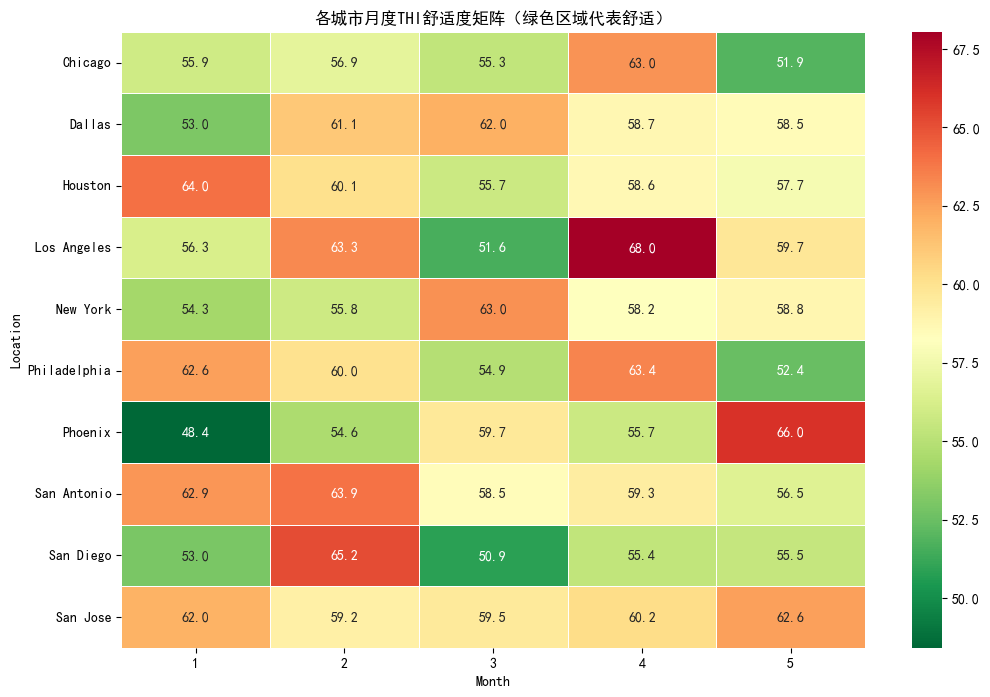

In [68]:
import seaborn as sns

# 数据透视：城市为行，月份为列
pivot_df = df.pivot_table(index='Location', columns='Month', values='THI', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_df, 
            cmap="RdYlGn_r",  # 红(热)-绿(舒适)反向色阶
            annot=True, 
            fmt=".1f",
            linewidths=0.5)
plt.title("各城市月度THI舒适度矩阵（绿色区域代表舒适）")

In [31]:
# 4.2 各城市舒适天数占比
comfort_days = df.groupby(['Location', 'Month'])['Comfort_Level'].apply(
    lambda x: (x == '舒适').mean() * 100
).unstack().round(1)

Text(0.5, 1.0, '各城市月度舒适天数占比(%)')

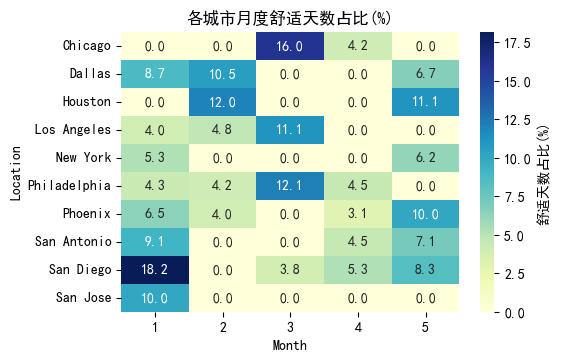

In [69]:
# 5.3 舒适度等级分布热力图
plt.figure(figsize=(12, 8)) 
plt.subplot(2, 2, 3)
heatmap_data = df.groupby(['Location', 'Month'])['Comfort_Level'].apply(
    lambda x: (x == '舒适').mean() * 100
).unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': '舒适天数占比(%)'})
plt.title('各城市月度舒适天数占比(%)')

### 输出结果统计

In [70]:
# 6. 输出统计结果
print("\n各城市THI统计：")
display(city_stats)

print("\n各城市月度舒适天数占比(%)：")
display(comfort_days)


各城市THI统计：


,THI_Mean,THI_Max,THI_Min,THI_Std
Location,,,,
Chicago,57.100481,100.82,20.92,19.088353
Dallas,58.620660,93.43,21.84,20.384103
Houston,59.407255,97.64,20.04,20.194383
Los Angeles,59.864426,100.84,22.44,19.488648
New York,58.125437,97.51,18.97,21.234719
Philadelphia,58.745214,96.95,20.62,20.532320
Phoenix,54.987913,92.07,11.55,21.539716
San Antonio,60.709487,96.72,20.46,20.034478
San Diego,55.939020,97.58,20.60,21.224656



各城市月度舒适天数占比(%)：


Month,1,2,3,4,5
Location,,,,,
Chicago,0.0,0.0,16.0,4.2,0.0
Dallas,8.7,10.5,0.0,0.0,6.7
Houston,0.0,12.0,0.0,0.0,11.1
Los Angeles,4.0,4.8,11.1,0.0,0.0
New York,5.3,0.0,0.0,0.0,6.2
Philadelphia,4.3,4.2,12.1,4.5,0.0
Phoenix,6.5,4.0,0.0,3.1,10.0
San Antonio,9.1,0.0,0.0,4.5,7.1
San Diego,18.2,0.0,3.8,5.3,8.3


### 可视化各城市舒适度

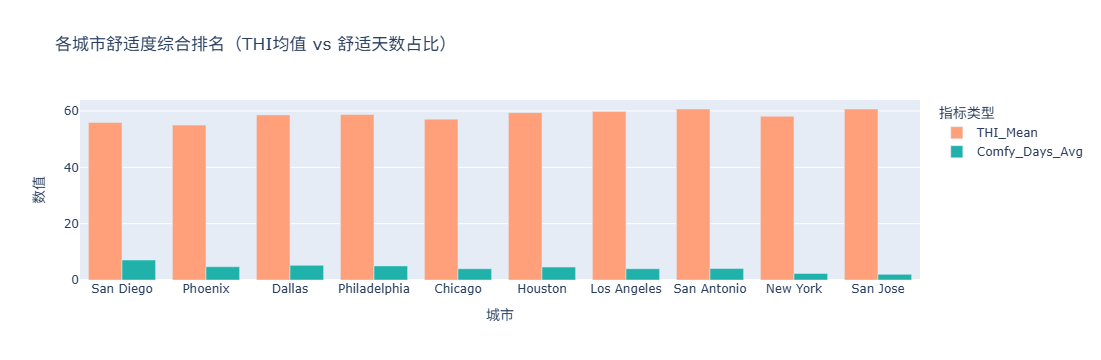

In [73]:
import pandas as pd
import plotly.express as px

# 数据准备
thi_stats = pd.DataFrame({
    'City': ['Chicago', 'Dallas', 'Houston', 'Los Angeles', 'New York', 
             'Philadelphia', 'Phoenix', 'San Antonio', 'San Diego', 'San Jose'],
    'THI_Mean': [57.10, 58.62, 59.41, 59.86, 58.13, 58.75, 54.99, 60.71, 55.94, 60.69],
    'THI_Std': [19.09, 20.38, 20.19, 19.49, 21.23, 20.53, 21.54, 20.03, 21.22, 19.00],
    'Comfy_Days_Avg': [4.0, 5.2, 4.6, 4.0, 2.3, 5.0, 4.7, 4.1, 7.1, 2.0] # 前5月舒适天均值
})

# 计算排名得分（THI均值越低越好，舒适天数越高越好）
thi_stats['Rank_Score'] = (thi_stats['THI_Mean']*0.6 + 
                         thi_stats['THI_Std']*0.2 - 
                         thi_stats['Comfy_Days_Avg']*2)
thi_stats = thi_stats.sort_values('Rank_Score').reset_index(drop=True)

# 可视化
fig = px.bar(
    thi_stats,
    x='City',
    y=['THI_Mean', 'Comfy_Days_Avg'],
    title='各城市舒适度综合排名（THI均值 vs 舒适天数占比）',
    labels={'value': '指标值', 'variable': '指标类型'},
    color_discrete_map={'THI_Mean': '#FFA07A', 'Comfy_Days_Avg': '#20B2AA'},
    barmode='group'
)
fig.update_layout(yaxis_title="数值", xaxis_title="城市")
fig.show()

### 聚类分析建模

In [74]:
# 准备聚类特征数据
cluster_features = df.groupby('Location').agg({
    'THI': ['mean', 'std', 'max', 'min'],  # THI统计特征
    'Temperature_C': 'mean',              # 平均温度
    'Humidity_pct': 'mean',               # 平均湿度
    'Wind_Speed_kmh': 'mean',             # 平均风速
    'Precipitation_mm': 'sum'             # 总降水量
}).reset_index()

# 扁平化多级列名
cluster_features.columns = ['_'.join(col).strip() if col[1] else col[0] 
                           for col in cluster_features.columns.values]

# 特征重命名简化
cluster_features = cluster_features.rename(columns={
    'THI_mean': 'THI_Mean',
    'THI_std': 'THI_Std',
    'THI_max': 'THI_Max',
    'THI_min': 'THI_Min',
    'Temperature_C_mean': 'Temp_Mean',
    'Humidity_pct_mean': 'Humidity_Mean',
    'Wind_Speed_kmh_mean': 'Wind_Mean',
    'Precipitation_mm_sum': 'Precip_Total'
})

# 标准化特征数据
scaler = StandardScaler()
features_to_scale = cluster_features.columns[1:]  # 排除Location列
scaled_features = scaler.fit_transform(cluster_features[features_to_scale])

In [75]:
# 确定最佳K值（肘部法则和轮廓系数）
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    
    if k > 1:  # 轮廓系数需要至少2个聚类
        silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

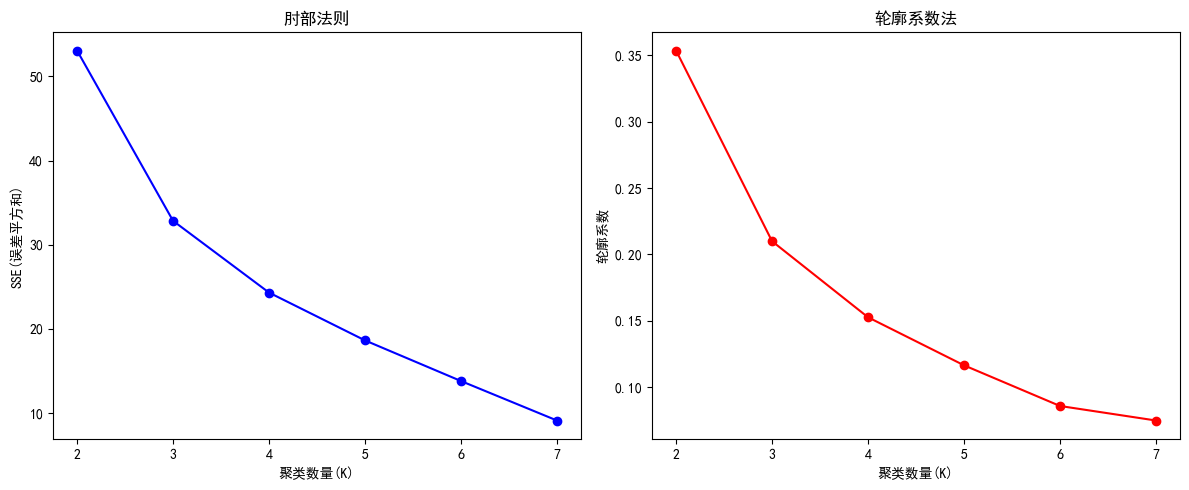

In [76]:
# 绘制肘部法则图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('聚类数量(K)')
plt.ylabel('SSE(误差平方和)')
plt.title('肘部法则')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, 'ro-')
plt.xlabel('聚类数量(K)')
plt.ylabel('轮廓系数')
plt.title('轮廓系数法')
plt.tight_layout()
plt.show()

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



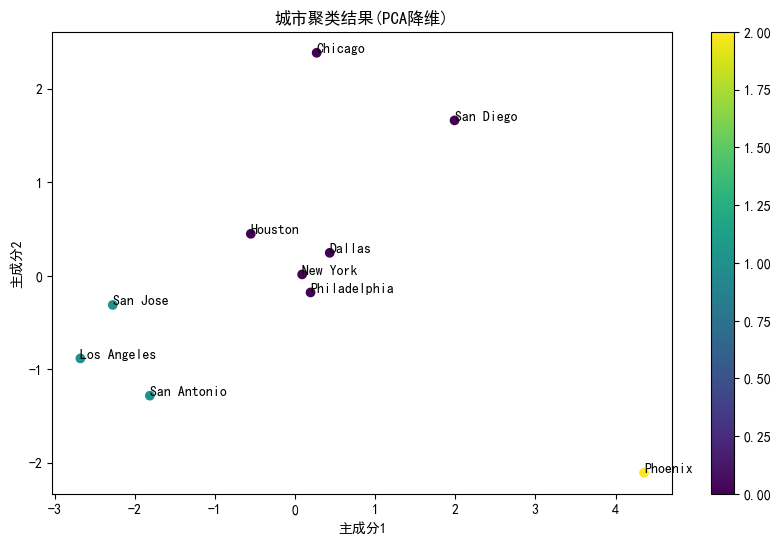


各聚类特征均值:


,THI_Mean,THI_Std,THI_Max,THI_Min,Temp_Mean,Humidity_Mean,Wind_Mean,Precip_Total
Cluster,,,,,,,,
0,57.989678,20.443089,97.321667,20.498333,14.510494,60.172793,14.949859,548.357316
1,60.422659,19.508899,98.926667,20.556667,16.191249,59.199676,14.317930,614.621304
2,54.987913,21.539716,92.070000,11.550000,12.375211,61.260551,14.817691,661.519612


In [82]:
# 根据图形选择最佳K值（这里假设K=3）
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据
cluster_features['Cluster'] = kmeans.labels_

# PCA降维可视化
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_features['Cluster'], cmap='viridis')
plt.colorbar(scatter)
for i, city in enumerate(cluster_features['Location']):
    plt.annotate(city, (pca_features[i, 0], pca_features[i, 1]))
plt.title('城市聚类结果(PCA降维)')
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.show()

# 分析聚类特征 - 只选择数值列进行均值计算
numeric_columns = cluster_features.select_dtypes(include=['number', 'float', 'int']).columns.tolist()
if 'Cluster' not in numeric_columns:
    numeric_columns.append('Cluster')  # 确保Cluster列存在

cluster_means = cluster_features[numeric_columns].groupby('Cluster').mean()
print("\n各聚类特征均值:")
display(cluster_means)

### 个性化旅游项目推荐

In [83]:
# 定义聚类特征描述和推荐活动
cluster_descriptions = {
    0: {
        'name': '温暖湿润型',
        'description': 'THI较高，温度适中，湿度较大，降水较多',
        'activities': ['参观城市景点', '进行沙滩水上运动']
    },
    1: {
        'name': '凉爽干燥型',
        'description': 'THI较低，温度凉爽，湿度较低，风速较大',
        'activities': ['户外活动', '温泉体验', '赏花、野餐、摄影']
    },
    2: {
        'name': '寒冷干燥型',
        'description': 'THI低，温度低，湿度低，风速大',
        'activities': ['滑雪', '温泉体验', '室内活动']
    }
}

# 为每个城市分配推荐活动
city_recommendations = []
for _, row in cluster_features.iterrows():
    cluster_info = cluster_descriptions[row['Cluster']]
    city_recommendations.append({
        '城市': row['Location'],
        '聚类类型': cluster_info['name'],
        '特征描述': cluster_info['description'],
        '推荐旅游项目': ', '.join(cluster_info['activities'])
    })

recommendations_df = pd.DataFrame(city_recommendations)
print("\n各城市春季旅游推荐:")
display(recommendations_df)

# 保存结果
recommendations_df.to_csv('../Data/city_travel_recommendations.csv', index=False, encoding='utf-8-sig')


各城市春季旅游推荐:


,城市,聚类类型,特征描述,推荐旅游项目
0,Chicago,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
1,Dallas,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
2,Houston,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
3,Los Angeles,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"户外活动, 温泉体验, 赏花、野餐、摄影"
4,New York,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
5,Philadelphia,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
6,Phoenix,寒冷干燥型,THI低，温度低，湿度低，风速大,"滑雪, 温泉体验, 室内活动"
7,San Antonio,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"户外活动, 温泉体验, 赏花、野餐、摄影"
8,San Diego,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点, 进行沙滩水上运动"
9,San Jose,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"户外活动, 温泉体验, 赏花、野餐、摄影"


数据列名: ['城市', '聚类类型', '特征描述', '推荐旅游项目']


C:\Users\35275\AppData\Local\Temp\ipykernel_24140\672620423.py:120: UserWarning:

Glyph 8226 (\N{BULLET}) missing from current font.

C:\Users\35275\AppData\Local\Temp\ipykernel_24140\672620423.py:121: UserWarning:

Glyph 8226 (\N{BULLET}) missing from current font.

D:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8226 (\N{BULLET}) missing from current font.



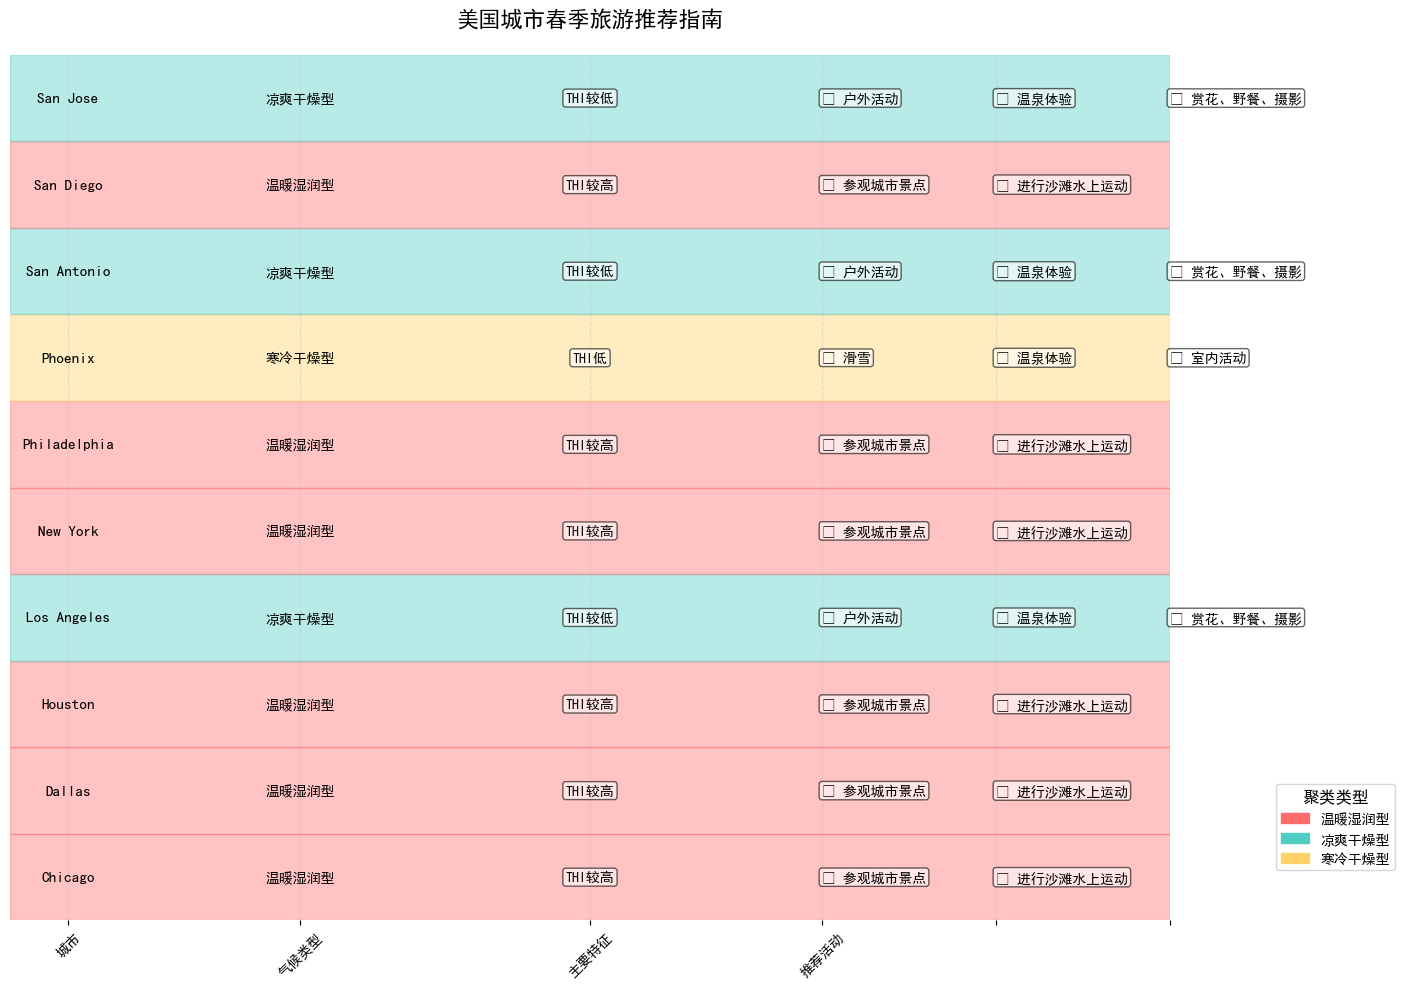

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 读取数据
try:
    df = pd.read_csv('../Data/city_travel_recommendations.csv')
    print("数据列名:", df.columns.tolist())  # 打印列名以便核查
except Exception as e:
    print(f"读取数据出错: {e}")

# 设置高对比度颜色映射
palette = {
    '温暖湿润型': '#FF6B6B',  # 鲜艳的红色
    '凉爽干燥型': '#4ECDC4',  # 明亮的青色
    '寒冷干燥型': '#FFD166',  # 活力的黄色
}

# 检查关键列是否存在
required_cols = ['城市', '聚类类型', '推荐旅游项目', '特征描述']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"缺少必要的列: {missing_cols}")

# 数据验证和预处理
df['特征描述'] = df['特征描述'].fillna('')  # 填充空值
df['推荐旅游项目'] = df['推荐旅游项目'].fillna('')  # 填充空值

# 创建画布
plt.figure(figsize=(14, 10))
ax = plt.gca()

# 绘制背景矩阵
for i, city in enumerate(df['城市']):
    # 聚类类型底色
    ax.add_patch(plt.Rectangle(
        (0, i), 10, 1, 
        color=palette[df.loc[i, '聚类类型']],
        alpha=0.4
    ))
    
    # 城市名称
    plt.text(
        0.5, i+0.5, city, 
        ha='center', va='center', 
        fontweight='bold',
        fontsize=11
    )
    
    # 聚类类型标签
    plt.text(
        2.5, i+0.5, df.loc[i, '聚类类型'], 
        ha='center', va='center',
        fontsize=10
    )
    
    # 特征描述（简写）
    feature_text = df.loc[i, '特征描述']
    try:
        feature_parts = feature_text.split('，')
        if feature_parts and feature_parts[0]:
            short_feature = feature_parts[0]
        else:
            short_feature = feature_text
    except Exception as e:
        print(f"处理第 {i} 行'特征描述'时出错: {e}")
        short_feature = feature_text
    
    plt.text(
        5, i+0.5, short_feature, 
        ha='center', va='center',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2')
    )
    
    # 推荐项目图标化展示
    activities = []
    try:
        activities = df.loc[i, '推荐旅游项目'].split(', ')
    except Exception as e:
        print(f"处理第 {i} 行'推荐旅游项目'时出错: {e}")
    
    for j, act in enumerate(activities[:3]):  # 最多显示3个
        plt.text(
            7 + j*1.5, i+0.5, 
            f"• {act}", 
            va='center',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2')
        )

# 设置坐标轴
ax.set_xlim(0, 10)
ax.set_ylim(0, len(df))
ax.set_xticks([0.5, 2.5, 5, 7, 8.5, 10])
ax.set_xticklabels(['城市', '气候类型', '主要特征', '推荐活动', '', ''], rotation=45, fontsize=10)
ax.set_yticks([])

# 添加标题和图例 - 调整图例到右下角
plt.title('美国城市春季旅游推荐指南', pad=20, fontsize=16, fontweight='bold')
legend_handles = [
    plt.Rectangle((0,0),1,1, color=palette[k], label=k) 
    for k in palette
]
plt.legend(
    handles=legend_handles, 
    title='聚类类型',
    bbox_to_anchor=(1.2, 0.05),  # 调整到右下角
    loc='lower right',  # 设置定位方式
    fontsize=10,
    title_fontsize=12,
    frameon=True,  # 添加边框
    facecolor='white',  # 背景颜色
    framealpha=0.8  # 背景透明度
)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('../Figures/旅游推荐矩阵.png', dpi=300, bbox_inches='tight')
plt.show()